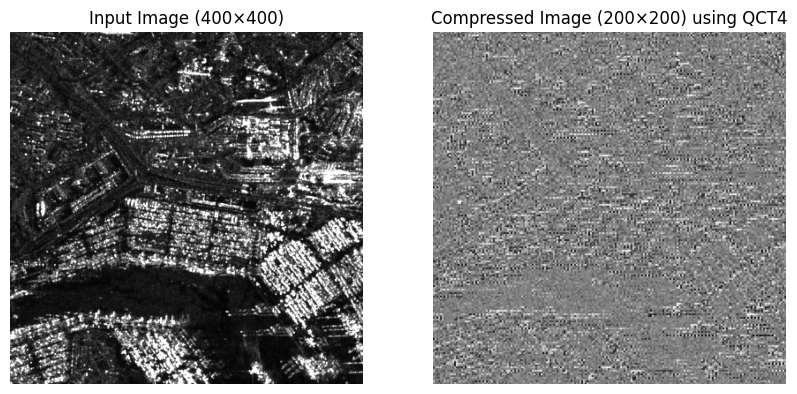

In [1]:
import cv2
import numpy as np
import pennylane as qml
import matplotlib.pyplot as plt
from qiskit_aer import Aer
from pennylane.templates.embeddings import AmplitudeEmbedding

# Load and preprocess the image
def load_and_preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read in grayscale
    img = cv2.resize(img, (400, 400))  # Downsize to 400x400
    return img

# Split the image into 16-pixel subblocks
def split_into_blocks(image, block_size=4):
    blocks = []
    for i in range(0, image.shape[0], block_size):
        for j in range(0, image.shape[1], block_size):
            block = image[i:i+block_size, j:j+block_size].flatten()
            blocks.append(block)
    return np.array(blocks)

# Normalize data for amplitude encoding
def normalize_block(block):
    norm = np.linalg.norm(block)
    return block / norm if norm != 0 else block

# Quantum device setup
dev = qml.device("qiskit.aer", wires=4, backend="qasm_simulator")

@qml.qnode(dev)
def quantum_compression_qct4(block):
    # Normalize and encode the data
    norm_block = normalize_block(block)
    AmplitudeEmbedding(features=norm_block, wires=[0, 1, 2, 3], normalize=True)
    
    # Apply Pauli-X operation to each qubit
    qml.PauliX(wires=0)
    qml.PauliX(wires=1)
    qml.PauliX(wires=2)
    qml.PauliX(wires=3)
    
    # Entangle qubits using CNOT operations
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 3])
    
    # Measurement in Pauli-Z basis
    return [qml.expval(qml.PauliZ(i)) for i in range(4)]

# Apply compression to all blocks
def compress_image(blocks):
    compressed_blocks = np.array([quantum_compression_qct4(block) for block in blocks])
    compressed_blocks = np.interp(compressed_blocks, [-1, 1], [0, 255])  # Scale back to [0, 255]
    return compressed_blocks.astype(np.uint8)

# Reconstruct compressed image
def reconstruct_image(compressed_blocks, img_size=200, block_size=2):
    compressed_image = np.zeros((img_size, img_size), dtype=np.uint8)
    index = 0
    for i in range(0, img_size, block_size):
        for j in range(0, img_size, block_size):
            compressed_image[i:i+block_size, j:j+block_size] = compressed_blocks[index].reshape((block_size, block_size))
            index += 1
    return compressed_image

# Main Execution
image_path = r"X:\College\BE\MajorProj\quantum\.venv\dataset_img1.png"  # Replace with your image path
input_image = load_and_preprocess_image(image_path)
blocks = split_into_blocks(input_image)
compressed_blocks = compress_image(blocks)
compressed_image_QCT4 = reconstruct_image(compressed_blocks)

# Display input and compressed output images
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.imshow(input_image, cmap='gray')
plt.title("Input Image (400×400)")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(compressed_image_QCT4, cmap='gray')
plt.title("Compressed Image (200×200) using QCT4")
plt.axis("off")

plt.show()
